In [3]:
import pandas as pd
import numpy as np

# Load the dataset
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Preview the data
print(train.head())
print(train.info())  # Check data types and missing values
print(train.describe())  # Summary statistics

     id                       SMILES      Tm  Group 1  Group 2  Group 3  \
0  2175        FC1=C(F)C(F)(F)C1(F)F  213.15        0        0        0   
1  1222  c1ccc2c(c1)ccc3Nc4ccccc4c23  407.15        0        0        0   
2  2994          CCN1C(C)=Nc2ccccc12  324.15        2        1        0   
3  1704                   CC#CC(=O)O  351.15        1        0        0   
4  2526                    CCCCC(S)C  126.15        2        3        0   

   Group 4  Group 5  Group 6  Group 7  ...  Group 415  Group 416  Group 417  \
0        0        0        0        0  ...          0          0          0   
1        0        0        0        0  ...          0          0          0   
2        0        0        0        0  ...          0          0          0   
3        0        0        0        0  ...          0          0          0   
4        0        0        0        0  ...          0          0          0   

   Group 418  Group 419  Group 420  Group 421  Group 422  Group 423  Group

In [ ]:
train.head()

In [ ]:
from rdkit import Chem
from rdkit.Chem import Descriptors

# Function to extract features from SMILES
def extract_rdkit_features(smiles):
    mol = Chem.MolFromSmiles(smiles)
    features = {
        'MolWt': Descriptors.MolWt(mol),  # Molecular weight
        'NumHAcceptors': Descriptors.NumHAcceptors(mol),  # Number of hydrogen bond acceptors
        'NumHDonors': Descriptors.NumHDonors(mol),  # Number of hydrogen bond donors
        'NumRings': Descriptors.RingCount(mol),  # Number of rings
        'TPSA': Descriptors.TPSA(mol),  # Topological polar surface area
    }
    return features

# Apply the feature extraction to all SMILES strings
smiles_features = train['SMILES'].apply(extract_rdkit_features)

# Convert the extracted features into a DataFrame
smiles_df = pd.DataFrame(smiles_features.tolist())

# Combine extracted features with the original dataset
train = pd.concat([train, smiles_df], axis=1)

In [18]:
print(train.isnull().sum())

id               0
SMILES           0
Tm               0
Group 1          0
Group 2          0
                ..
MolWt            0
NumHAcceptors    0
NumHDonors       0
NumRings         0
TPSA             0
Length: 432, dtype: int64


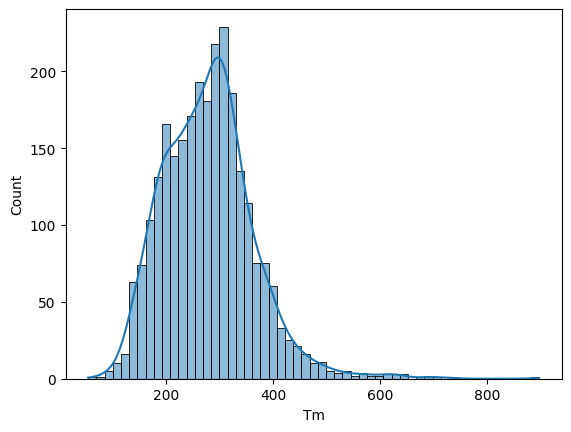

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(train['Tm'], kde=True)
plt.show()

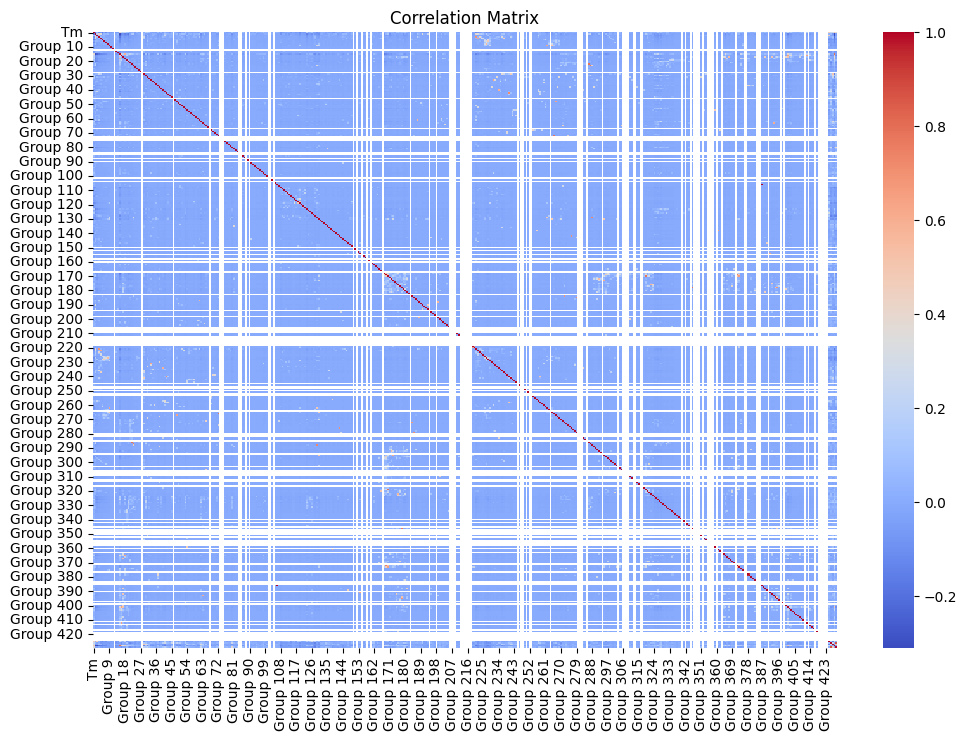

In [20]:
correlation_matrix = train.drop(['id', 'SMILES'], axis=1).corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False)
plt.title('Correlation Matrix')
plt.show()

In [33]:
X = train.drop(['id', 'SMILES', 'Tm'], axis=1)  # Features
y = train['Tm']  # Target variable

In [34]:
X.fillna(X.mean(), inplace=True)

In [35]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train a Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on validation set
y_pred = model.predict(X_val)

# Evaluate with MAE
mae = mean_absolute_error(y_val, y_pred)
print(f'Mean Absolute Error (MAE): {mae}')

Mean Absolute Error (MAE): 37.997824790059575


In [37]:
from xgboost import XGBRegressor

# Train XGBoost model
xgb_model = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=10, random_state=42)
xgb_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_xgb = xgb_model.predict(X_val)
mae_xgb = mean_absolute_error(y_val, y_pred_xgb)
print(f'XGBoost MAE: {mae_xgb}')

XGBoost MAE: 32.65674134903956


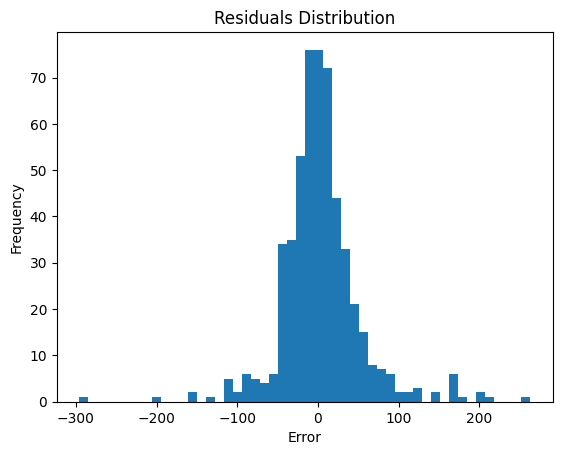

In [38]:
import matplotlib.pyplot as plt

residuals = y_val - y_pred_xgb
plt.hist(residuals, bins=50)
plt.title('Residuals Distribution')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.show()

,id,SMILES,Tm,Group 1,Group 2,Group 3,Group 4,Group 5,Group 6,Group 7,...,Group 420,Group 421,Group 422,Group 423,Group 424,MolWt,NumHAcceptors,NumHDonors,NumRings,TPSA
0,2175,FC1=C(F)C(F)(F)C1(F)F,213.15,0,0,0,0,0,0,0,...,0,0,0,0,0,162.032,0,0,1,0.00
1,1222,c1ccc2c(c1)ccc3Nc4ccccc4c23,407.15,0,0,0,0,0,0,0,...,0,0,0,0,0,217.271,0,1,4,15.79
2,2994,CCN1C(C)=Nc2ccccc12,324.15,2,1,0,0,0,0,0,...,0,0,0,0,0,160.220,2,0,2,17.82
3,1704,CC#CC(=O)O,351.15,1,0,0,0,0,0,0,...,0,0,0,0,0,84.074,1,1,0,37.30
4,2526,CCCCC(S)C,126.15,2,3,0,0,0,0,0,...,0,0,0,0,0,118.245,1,1,0,0.00


        Feature  Importance
427    NumRings    0.113925
428        TPSA    0.053640
424       MolWt    0.022254
30     Group 31    0.020251
85     Group 86    0.019576
426  NumHDonors    0.018893
224   Group 225    0.016998
40     Group 41    0.015989
372   Group 373    0.015508
365   Group 366    0.014047


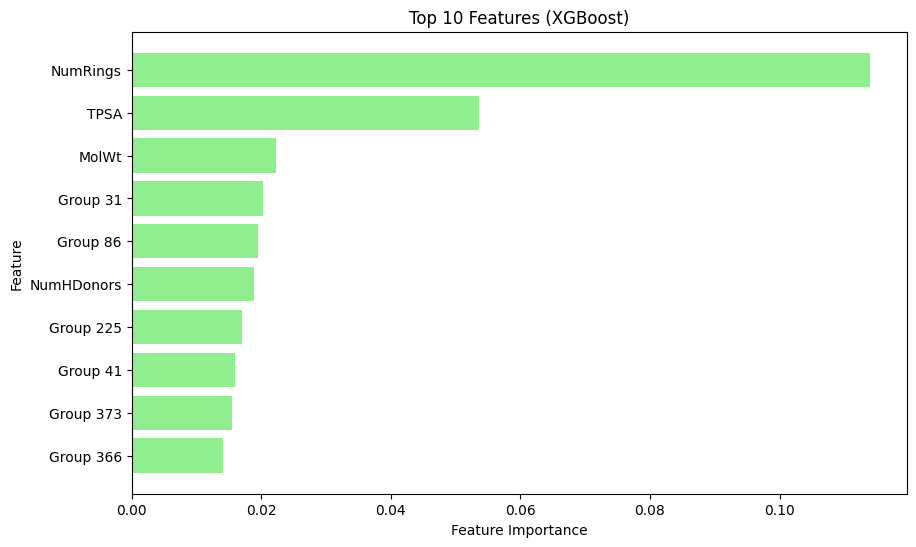

In [39]:
from xgboost import XGBRegressor

# Train XGBoost model
xgb_model = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=10, random_state=42)
xgb_model.fit(X_train, y_train)

# Get feature importance scores
feature_importances_xgb = xgb_model.feature_importances_

# Create a DataFrame for feature importance
importance_df_xgb = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances_xgb
})

# Sort by importance
importance_df_xgb = importance_df_xgb.sort_values(by='Importance', ascending=False)

# Select top 10 features
top_10_features_xgb = importance_df_xgb.head(10)
print(top_10_features_xgb)

# Visualize the top 10 features
plt.figure(figsize=(10, 6))
plt.barh(top_10_features_xgb['Feature'], top_10_features_xgb['Importance'], color='lightgreen')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 10 Features (XGBoost)')
plt.gca().invert_yaxis()
plt.show()

In [45]:
# Import necessary libraries
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression

# Load datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Step 1: Function to extract RDKit features from SMILES strings
def extract_rdkit_features(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:  # Handle invalid SMILES strings
        return {
            'MolWt': None,
            'NumHAcceptors': None,
            'NumHDonors': None,
            'NumRings': None,
            'TPSA': None
        }
    features = {
        'MolWt': Descriptors.MolWt(mol),  # Molecular weight
        'NumHAcceptors': Descriptors.NumHAcceptors(mol),  # Hydrogen bond acceptors
        'NumHDonors': Descriptors.NumHDonors(mol),  # Hydrogen bond donors
        'NumRings': Descriptors.RingCount(mol),  # Number of rings
        'TPSA': Descriptors.TPSA(mol),  # Topological polar surface area
    }
    return features

# Step 2: Apply RDKit feature extraction to train and test datasets
print("Extracting RDKit features...")
smiles_features_train = train['SMILES'].apply(extract_rdkit_features)
smiles_features_test = test['SMILES'].apply(extract_rdkit_features)

# Convert extracted features into DataFrames
train_rdkit = pd.DataFrame(smiles_features_train.tolist())
test_rdkit = pd.DataFrame(smiles_features_test.tolist())

# Step 3: Combine RDKit features with original datasets
train = pd.concat([train, train_rdkit], axis=1)
test = pd.concat([test, test_rdkit], axis=1)

print("RDKit features added to datasets!")

# Step 4: Handle missing values (e.g., invalid SMILES)
print("Handling missing values...")
# Fill missing values for numeric columns only in the train DataFrame
numeric_columns_train = train.select_dtypes(include=['float64', 'int64']).columns  # Select numeric columns
train[numeric_columns_train] = train[numeric_columns_train].fillna(train[numeric_columns_train].mean())

# Fill missing values for numeric columns only in the test DataFrame
numeric_columns_test = test.select_dtypes(include=['float64', 'int64']).columns  # Select numeric columns
test[numeric_columns_test] = test[numeric_columns_test].fillna(test[numeric_columns_test].mean())

# Define features and target for training
X = train.drop(['id', 'SMILES', 'Tm'], axis=1)  # Drop irrelevant columns
y = train['Tm']  # Target variable

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train baseline XGBoost model
print("Training baseline XGBoost model...")
baseline_model = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=10, random_state=42)
baseline_model.fit(X_train, y_train)

# Predict on validation set and calculate MAE
print("Evaluating baseline model...")
y_pred_val_baseline = baseline_model.predict(X_val)
mae_baseline = mean_absolute_error(y_val, y_pred_val_baseline)
print(f"Baseline MAE with RDKit features: {mae_baseline}")

# Step 5: Hyperparameter Tuning
print("Performing hyperparameter tuning...")
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}
grid_search = GridSearchCV(
    estimator=XGBRegressor(random_state=42),
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=5
)
grid_search.fit(X_train, y_train)

# Best model after tuning
best_model = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

# Evaluate best model
y_pred_val_best = best_model.predict(X_val)
mae_best = mean_absolute_error(y_val, y_pred_val_best)
print(f"MAE after hyperparameter tuning: {mae_best}")

# Step 6: Ensemble Modeling
print("Performing ensemble modeling...")
# Define base models
rf_model = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

# Stacking ensemble
stacking_model = StackingRegressor(
    estimators=[
        ('xgb', best_model),
        ('rf', rf_model)
    ],
    final_estimator=LinearRegression()
)
stacking_model.fit(X_train, y_train)

# Evaluate stacking model
y_pred_val_stacking = stacking_model.predict(X_val)
mae_stacking = mean_absolute_error(y_val, y_pred_val_stacking)
print(f"MAE with stacking model: {mae_stacking}")

# Step 7: Submission
print("Generating submission file...")
X_test = test.drop(['id', 'SMILES'], axis=1)  # Drop irrelevant columns
test_predictions = stacking_model.predict(X_test)

submission = pd.DataFrame({'id': test['id'], 'Tm': test_predictions})
submission.to_csv('submission_stacking_rdkit.csv', index=False)

print("Submission file created successfully!")

Extracting RDKit features...
RDKit features added to datasets!
Handling missing values...
Training baseline XGBoost model...
Evaluating baseline model...
Baseline MAE with RDKit features: 32.65674134903956
Performing hyperparameter tuning...
Best Parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 300, 'subsample': 0.6}
MAE after hyperparameter tuning: 31.731333833447543
Performing ensemble modeling...
MAE with stacking model: 31.79732721011723
Generating submission file...
Submission file created successfully!


1926.7119784240067
